<a href="https://colab.research.google.com/github/MocktaiLEngineer/PyNN-Less/blob/main/micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [114]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [115]:
import math

class Value():
    def __init__(self, data, _prev = (), _op = '', label = ''):
        self.data = data
        self._prev = set(_prev)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda : None

    def __repr__(self):
        return f'Value({self.data})'

    def __add__(self, other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data, _prev = (self, other), _op = '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __radd__(self, other):
        return self + other

    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data, _prev = (self, other), _op = '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * (other**-1)

    def __pow__(self, other):
        assert isinstance(other, (int,float))
        out = Value(self.data ** other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * (self.data ** (other - 1))) * out.grad
        out._backward = _backward

        return out 

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [116]:
a = Value(2.0); a.label = 'a'
b = Value(3.0); b.label = 'b'
c = Value(4.0); c.label = 'c'
d = a * b; d.label = 'd'
e = d + c; e.label = 'e'
f = e.tanh(); f.label = 'f'
g = f ** 2; g.label = 'g'

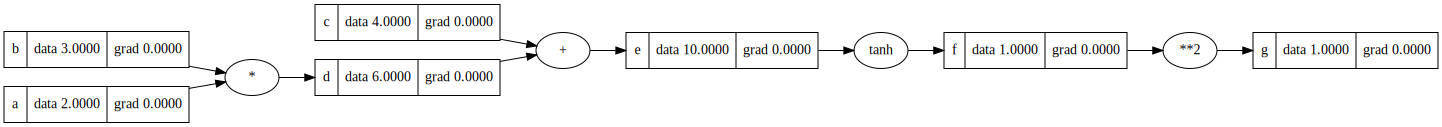

In [117]:
draw_dot(g)

In [118]:
g.backward()

In [119]:
import random

class Neuron():
    def __init__(self,num_of_inputs):
        self.w = [Value(random.uniform(-1,1)) for _ in range(num_of_inputs)]
        self.b = Value(random.uniform(-1,1))
    
    def __call__(self,x):
        activation = sum((wi*xi for wi,xi in zip(self.w,x)), self.b)
        out = activation.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self,num_of_inputs,num_of_neurons):
        self.neurons = [Neuron(num_of_inputs) for _ in range(num_of_neurons)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]



In [120]:
x = [2.0,3.0,-1.0]
n = MLP(3,[4,4,1])
n(x)

Value(-0.7587673200963323)

In [121]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [122]:
for i in range(20):

    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((ypred - ys)**2 for ys,ypred in zip(ys,ypred))

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(i,loss.data)

0 6.323624723207759
1 2.74775036100073
2 0.42558487802106504
3 0.28042017494672145
4 0.21144427773498548
5 0.1685280913116262
6 0.1391644620681277
7 0.11791475756049452
8 0.10190489295319285
9 0.08946016533288832
10 0.07954056792023584
11 0.07146854151733287
12 0.06478529161314353
13 0.059170006478423326
14 0.05439214795114711
15 0.05028210738229982
16 0.04671252309026623
17 0.04358602441914382
18 0.04082697795736103
19 0.038375798456423915
